In [20]:
import sys
import os
import time
import numpy as n

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

from cryoem.cryoio import ctf
from cryoem.cryoio import mrc

from cryoem.util import format_timedelta

from cryoem import cryoem
from cryoem import geom
from cryoem import cryoops
from cryoem import density
from cryoem import sincint

import numpy.fft as fourier

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['figure.dpi'] = 300
plt.style.use(['dark_background'])

In [45]:
defocus_min = 10000
defocus_max = 20000
defocus_ang_min = 0
defocus_ang_max = 360
accel_kv = 300
amp_contrast = 0.07
phase_shift = 0
scale = 1
spherical_abberr = 2.7
mag = 10000.0

n_particles = 10
n_gridpoints = 8
snr = 0.05

kernel = 'lanczos'
ksize = int(6)
rad = 0.95
shift_sigma = 0
bfactor = 50.0

In [74]:
# Read the volume data and compute fft
vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod_bigbox.mrc", inc_header=True)
# vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod.mrc", inc_header=True)

boxSize = int(vol.shape[0])
pxSize = (hdr['xlen']/hdr['nx'])

premult = cryoops.compute_premultiplier(boxSize, kernel, ksize) 

V = density.real_to_fspace(premult.reshape((1,1,-1)) * premult.reshape((1,-1,1)) * premult.reshape((-1,1,1)) * vol)

vol_f = fourier.fftshift(fourier.fft2(vol))

# plt.imshow(n.abs(vol[154,:,:]))
# sigma_noise = vol.std()/snr
# print('Noise sigma: ' + str(sigma_noise))
# plt.savefig('read_vol.png')

vol.max()

20.603054

In [59]:
particle_metadata = [{} for _ in range(n_particles)]
particles = n.empty((n_particles, boxSize, boxSize), dtype=density.real_t)
starfile = []
TtoF = sincint.gentrunctofull(N=boxSize, rad=rad)

ctfed = []
noised = []
fspace = []

tic = time.time()
for i,p in enumerate(particle_metadata):
    ellapse_time = time.time() - tic
    remain_time = float(n_particles - i)*ellapse_time/max(i,1)
    print("\r%.2f Percent Complete (%d particles done)... (Elapsed: %s, Remaining: %s)" % (i/float(n_particles)*100.0,i,format_timedelta(ellapse_time),format_timedelta(remain_time)), end="")
    
    # GENERATE PARTICLE ORIENTATION AND CTF PARAMETERS
    # Random orientation vector and get spherical angles
    pt = n.random.randn(3)
    pt /= n.linalg.norm(pt)
    psi = 2*n.pi*n.random.rand()
    
    # Compute Euler angles from a direction vector. Output EA is tuple with phi, theta, psi.
    EA = geom.genEA(pt)[0]
    EA[2] = psi
    
    p['phi'] = EA[0]*180.0/n.pi
    p['theta'] = EA[1]*180.0/n.pi
    p['psi'] = EA[2]*180.0/n.pi
    
    # Compute a random shift
    shift = n.random.randn(2) * shift_sigma
    p['shift_x'] = shift[0]
    p['shift_y'] = shift[1]
    
    # Random defocus within the ranges
    base_defocus = n.random.uniform(defocus_min, defocus_max)
    p['defocus_a'] = base_defocus + n.random.uniform(-500,500)
    p['defocus_b'] = base_defocus + n.random.uniform(-500,500)
    p['astig_angle'] = n.random.uniform(defocus_ang_min, defocus_ang_max)
    
    # CREATE THE PROJECTIONS AND APPLY CTFS
    # Generate rotation matrix based on the Euler Angles
    R = geom.rotmat3D_EA(*EA)[:,0:2]
    slop = cryoops.compute_projection_matrix([R], boxSize, kernel, ksize, rad, 'rots')
    S = cryoops.compute_shift_phases(shift.reshape((1,2)), boxSize, rad)[0]
    D = slop.dot(V.reshape((-1,)))
    D *= S
      
    # Generate the CTF
    C = ctf.compute_full_ctf(None, boxSize, pxSize, accel_kv, spherical_abberr, amp_contrast, p['defocus_a'], p['defocus_b'], n.radians(p['astig_angle']), 1, bfactor)
    particles[i] = density.fspace_to_real((TtoF.dot(D)).reshape((boxSize,boxSize)))
    fspace.append(D)
    # Apply CTF to the projection and write to particles array
    ctf_distorted = density.fspace_to_real((C*TtoF.dot(D)).reshape((boxSize,boxSize)))
    ctfed.append(ctf_distorted)
    noise_added = ctf_distorted + n.require(n.random.randn(boxSize, boxSize)*10,dtype=density.real_t)
    noised.append(-noise_added)
    
    starfile_line = [str(amp_contrast), 
                     str(p['psi']), 
                     str(p['phi']), 
                     str(p['theta']),
                     str(1),
                     str(p['astig_angle']),                     
                     str(p['defocus_a']),
                     str(p['defocus_b']),
                     str(pxSize),
                     "%d@/simulated_particles.mrcs" % (i+1),
                     str(mag),
                     str(0),
                     str(0),
                     str(0),
                     str(spherical_abberr),
                     str(accel_kv)]
    starfile.append(starfile_line)
                          

90.00 Percent Complete (9 particles done)... (Elapsed: 00:00:02s, Remaining: 00:00:00s)

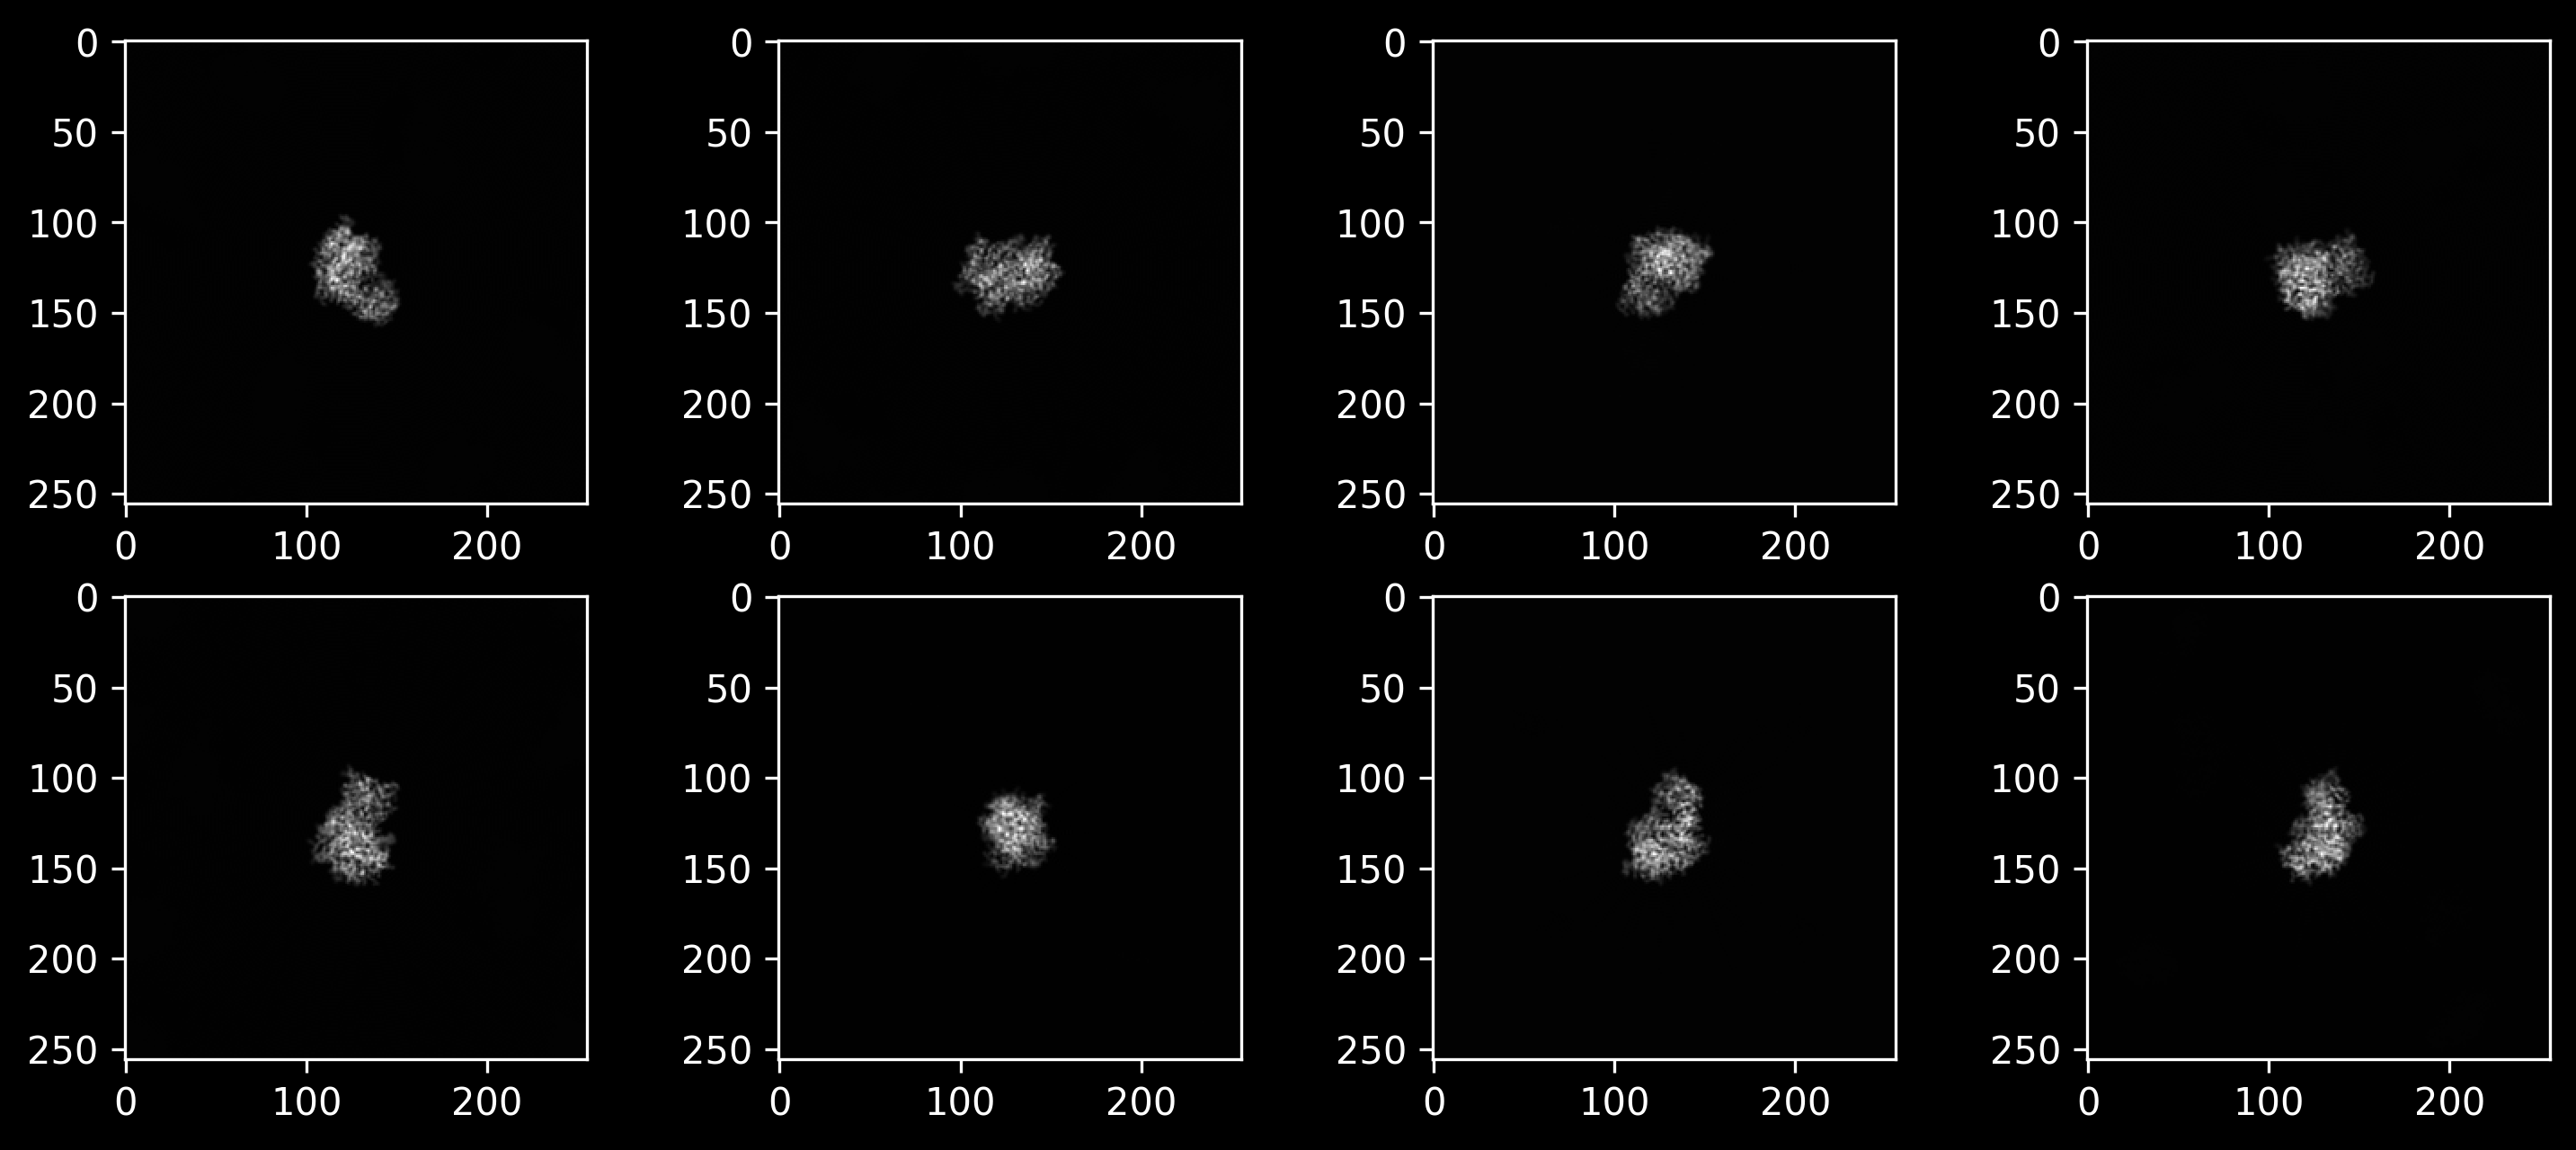

In [64]:
# Plot the first 8 images
fig = plt.figure(figsize=(12, 5))
col = 4
row = 2
for i in range(1, col*row +1):
    img = particles[i]
    fig.add_subplot(row, col, i)
    plt.imshow(img, cmap='gray')
plt.savefig('projections.png')
plt.show()


In [60]:
# Write the particle stack
mrc.writeMRC('output/simulated_particles.mrcs', n.transpose(particles,(1,2,0)), pxSize)

In [61]:
# Write the starfile
f = open('output/simulated_particles.star', 'w')
# Write the header
f.write("\ndata_images\n\nloop_\n_rlnAmplitudeContrast #1 \n_rlnAnglePsi #2 \n_rlnAngleRot #3 \n_rlnAngleTilt #4 \n_rlnClassNumber #5 \n_rlnDefocusAngle #6 \n_rlnDefocusU #7 \n_rlnDefocusV #8 \n_rlnDetectorPixelSize #9 \n_rlnImageName #10 \n_rlnMagnification #11 \n_rlnOriginX #12 \n_rlnOriginY #13 \n_rlnPhaseShift #14 \n_rlnSphericalAberration #15\n_rlnVoltage #16\n\n")
# Write the particle information
for l in starfile:
    f.write(' '.join(l) + '\n')
f.close()